<a href="https://colab.research.google.com/github/alyssc/Neuro140/blob/master/Neuro140AlyssaChen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Neuro 140 Final Project**
Alyssa Chen

---
Citation: Used [PyTorch Tutorials](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) and Colin's [Concept Acquisition Code](https://colab.research.google.com/drive/1wo6Bqq0YM2D8SqUcM6fc-MuTvE5_dfB4) as the basis for my own code. 

In [0]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import copy

import torch.utils.data
import torch.backends.cudnn as cudnn
from torchvision.utils import save_image
from torch.utils.data import Dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# handdrawn test set: 31 images each of bees and ants. See Google Drive for more info. 

# training set are real images, val set is handdrawn
data_dir_mixed = "/content/gdrive/My Drive/datasets/Mixed"

# training set and val set are both real
data_dir_real = "/content/gdrive/My Drive/datasets/smaller_hymenoptera_data"

# training set and val set are both handdrawn
data_dir_handdrawn = "/content/gdrive/My Drive/datasets/TUBerlin"

data_dir_handdrawn2 = "/content/gdrive/My Drive/datasets/modifiedTUBerlin"

num_classes = 2
batch_size = 10
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Copying model if successful
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(num_classes, feature_extract, use_pretrained):
    model_ft = models.vgg16_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)


    return model_ft


In [0]:
def initialize_modified_model(num_classes, feature_extract, use_pretrained):
    model_ft = models.vgg16_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.features[0] = nn.Conv2d(3, 64, kernel_size=(15,15), stride=(1, 1), padding=(1, 1))
    model_ft.features[6] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    model_ft.features[13] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    model_ft.features[23] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    model_ft.features[33] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    model_ft.features[43] = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

    
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    return model_ft

In [0]:
# Data augmentation and normalization for training
# Normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(244),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

real_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir_real, x), data_transforms[x]) for x in ['train', 'val']}
real_dataloaders_dict = {x: torch.utils.data.DataLoader(real_image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

mixed_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir_mixed, x), data_transforms[x]) for x in ['train', 'val']}
mixed_dataloaders_dict = {x: torch.utils.data.DataLoader(mixed_image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

handdrawn_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir_handdrawn, x), data_transforms[x]) for x in ['train', 'val']}
handdrawn_dataloaders_dict = {x: torch.utils.data.DataLoader(handdrawn_image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

handdrawn2_image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir_handdrawn2, x), data_transforms[x]) for x in ['train', 'val']}
handdrawn2_dataloaders_dict = {x: torch.utils.data.DataLoader(handdrawn2_image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

                              
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
# Initialize the model for this run
model_for_real = initialize_model(num_classes, feature_extract, use_pretrained = True)

# Print the model we just instantiated
print(model_for_real)


# Send the model to GPU
model_for_real = model_for_real.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_for_real.parameters()

params_to_update = []
for name,param in model_for_real.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)


# Observe which parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.torch/models/vgg16_bn-6c64b313.pth
553507836it [00:07, 74860683.98it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_for_real, hist_for_real = train_model(model_for_real, real_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.6112 Acc: 0.6860
val Loss: 0.3550 Acc: 0.9194

Epoch 1/24
----------
train Loss: 0.3724 Acc: 0.9070
val Loss: 0.2268 Acc: 0.9355

Epoch 2/24
----------
train Loss: 0.2499 Acc: 0.9302
val Loss: 0.1839 Acc: 0.9516

Epoch 3/24
----------
train Loss: 0.2306 Acc: 0.9186
val Loss: 0.2029 Acc: 0.9355

Epoch 4/24
----------
train Loss: 0.1640 Acc: 0.9767
val Loss: 0.1941 Acc: 0.9355

Epoch 5/24
----------
train Loss: 0.2007 Acc: 0.9186
val Loss: 0.1896 Acc: 0.9355

Epoch 6/24
----------
train Loss: 0.2609 Acc: 0.8721
val Loss: 0.2092 Acc: 0.9194

Epoch 7/24
----------
train Loss: 0.1546 Acc: 0.9535
val Loss: 0.1832 Acc: 0.9355

Epoch 8/24
----------
train Loss: 0.1528 Acc: 0.9302
val Loss: 0.1963 Acc: 0.9355

Epoch 9/24
----------
train Loss: 0.1349 Acc: 0.9651
val Loss: 0.2007 Acc: 0.9355

Epoch 10/24
----------
train Loss: 0.1257 Acc: 0.9535
val Loss: 0.1956 Acc: 0.9355

Epoch 11/24
----------
train Loss: 0.1712 Acc: 0.9419
val Loss: 0.1873 Acc: 0.9516

Ep

In [0]:
# Complete untrained model for comparison, on the mixed dataset
scratch_model = initialize_model(num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, mixed_dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs)


Epoch 0/24
----------
train Loss: 1.0604 Acc: 0.5820
val Loss: 16.5543 Acc: 0.5000

Epoch 1/24
----------
train Loss: 1.4790 Acc: 0.5984
val Loss: 8.5725 Acc: 0.5000

Epoch 2/24
----------
train Loss: 1.8581 Acc: 0.5820
val Loss: 4.2030 Acc: 0.5000

Epoch 3/24
----------
train Loss: 1.7965 Acc: 0.5615
val Loss: 9.1379 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.9924 Acc: 0.5779
val Loss: 2.8816 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.9333 Acc: 0.5984
val Loss: 0.6591 Acc: 0.5000

Epoch 6/24
----------
train Loss: 1.0711 Acc: 0.5451
val Loss: 5.0743 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.8072 Acc: 0.5656
val Loss: 5.6657 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.9776 Acc: 0.5738
val Loss: 3.7404 Acc: 0.5000

Epoch 9/24
----------
train Loss: 1.1242 Acc: 0.5369
val Loss: 21.2012 Acc: 0.5000

Epoch 10/24
----------
train Loss: 0.9536 Acc: 0.5738
val Loss: 3.7580 Acc: 0.5000

Epoch 11/24
----------
train Loss: 0.7570 Acc: 0.5820
val Loss: 7.8513 Acc: 0.5000



In [0]:
# Pretrained model using fixed feature extraction on handdrawn dataset
model_for_handdrawn = initialize_model(num_classes, feature_extract, use_pretrained = True)

model_for_handdrawn = model_for_handdrawn.to(device)

model_for_handdrawn,hist_for_handdrawn = train_model(model_for_handdrawn, handdrawn_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)




Epoch 0/24
----------
train Loss: 0.7013 Acc: 0.5930
val Loss: 0.6880 Acc: 0.5811

Epoch 1/24
----------
train Loss: 0.6970 Acc: 0.5233
val Loss: 0.7061 Acc: 0.5405

Epoch 2/24
----------
train Loss: 0.7122 Acc: 0.5000
val Loss: 0.7175 Acc: 0.5135

Epoch 3/24
----------
train Loss: 0.6993 Acc: 0.5581
val Loss: 0.7186 Acc: 0.5135

Epoch 4/24
----------
train Loss: 0.6976 Acc: 0.5349
val Loss: 0.7181 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.7160 Acc: 0.4767
val Loss: 0.7164 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.6921 Acc: 0.5000
val Loss: 0.7082 Acc: 0.5270

Epoch 7/24
----------
train Loss: 0.7231 Acc: 0.4651
val Loss: 0.7064 Acc: 0.5405

Epoch 8/24
----------
train Loss: 0.6845 Acc: 0.5581
val Loss: 0.7046 Acc: 0.5405

Epoch 9/24
----------
train Loss: 0.7106 Acc: 0.4884
val Loss: 0.7029 Acc: 0.5405

Epoch 10/24
----------
train Loss: 0.6731 Acc: 0.5930
val Loss: 0.7051 Acc: 0.5405

Epoch 11/24
----------
train Loss: 0.7106 Acc: 0.5116
val Loss: 0.7056 Acc: 0.5405

Ep

In [0]:
# Pretrained model using fixed feature extraction on modified handdrawn dataset 

model_for_handdrawn2 = initialize_model(num_classes, feature_extract, use_pretrained = True)

model_for_handdrawn2 = model_for_handdrawn2.to(device)

model_for_handdrawn2,hist_for_handdrawn2 = train_model(model_for_handdrawn2, handdrawn2_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)



Epoch 0/24
----------
train Loss: 0.7192 Acc: 0.4714
val Loss: 0.6832 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.7062 Acc: 0.4857
val Loss: 0.6862 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.6993 Acc: 0.5143
val Loss: 0.6936 Acc: 0.4500

Epoch 3/24
----------
train Loss: 0.7130 Acc: 0.5000
val Loss: 0.6895 Acc: 0.4500

Epoch 4/24
----------
train Loss: 0.7360 Acc: 0.4643
val Loss: 0.6947 Acc: 0.4500

Epoch 5/24
----------
train Loss: 0.7210 Acc: 0.4643
val Loss: 0.6939 Acc: 0.4500

Epoch 6/24
----------
train Loss: 0.7040 Acc: 0.5071
val Loss: 0.6940 Acc: 0.4500

Epoch 7/24
----------
train Loss: 0.7266 Acc: 0.4786
val Loss: 0.6940 Acc: 0.4500

Epoch 8/24
----------
train Loss: 0.7207 Acc: 0.4786
val Loss: 0.6944 Acc: 0.4500

Epoch 9/24
----------
train Loss: 0.7121 Acc: 0.4929
val Loss: 0.6960 Acc: 0.4500

Epoch 10/24
----------
train Loss: 0.7365 Acc: 0.4500
val Loss: 0.6929 Acc: 0.4500

Epoch 11/24
----------
train Loss: 0.7233 Acc: 0.4571
val Loss: 0.6950 Acc: 0.4500

Ep

In [0]:
# Pretrained model using fixed feature extraction on mixed dataset (trained using real, evaluated on handdrawn)
model_for_mixed = initialize_model(num_classes, feature_extract, use_pretrained = True)

model_for_mixed = model_for_mixed.to(device)

model_for_mixed,hist_for_mixed = train_model(model_for_mixed, mixed_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.7648 Acc: 0.4180
val Loss: 0.6919 Acc: 0.4730

Epoch 1/24
----------
train Loss: 0.7551 Acc: 0.4303
val Loss: 0.6915 Acc: 0.5135

Epoch 2/24
----------
train Loss: 0.7515 Acc: 0.4180
val Loss: 0.6893 Acc: 0.5405

Epoch 3/24
----------
train Loss: 0.7329 Acc: 0.4590
val Loss: 0.6942 Acc: 0.4730

Epoch 4/24
----------
train Loss: 0.7226 Acc: 0.4959
val Loss: 0.6891 Acc: 0.5135

Epoch 5/24
----------
train Loss: 0.7703 Acc: 0.4139
val Loss: 0.6887 Acc: 0.5135

Epoch 6/24
----------
train Loss: 0.7441 Acc: 0.4590
val Loss: 0.6877 Acc: 0.5135

Epoch 7/24
----------
train Loss: 0.7384 Acc: 0.4221
val Loss: 0.6895 Acc: 0.5405

Epoch 8/24
----------
train Loss: 0.7541 Acc: 0.4180
val Loss: 0.6917 Acc: 0.5135

Epoch 9/24
----------
train Loss: 0.7813 Acc: 0.3852
val Loss: 0.6814 Acc: 0.5270

Epoch 10/24
----------
train Loss: 0.7389 Acc: 0.4262
val Loss: 0.6910 Acc: 0.4730

Epoch 11/24
----------
train Loss: 0.7438 Acc: 0.4344
val Loss: 0.6859 Acc: 0.5135

Ep

In [0]:
#Changing to finetuning, not just fixed feature extraction

feature_extract = True

# Initialize the model for this run
model_for_real = initialize_model(num_classes, feature_extract, use_pretrained = True)
model_for_real = model_for_real.to(device)

params_to_update = model_for_real.parameters()
print("Params to learn:")

for name,param in model_for_real.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [0]:
model_for_real, hist_for_real_finetune = train_model(model_for_real, real_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.5691 Acc: 0.6977
val Loss: 0.3324 Acc: 0.9516

Epoch 1/24
----------
train Loss: 0.3959 Acc: 0.8372
val Loss: 0.2156 Acc: 0.9516

Epoch 2/24
----------
train Loss: 0.2578 Acc: 0.9302
val Loss: 0.1820 Acc: 0.9516

Epoch 3/24
----------
train Loss: 0.2539 Acc: 0.9070
val Loss: 0.2065 Acc: 0.9355

Epoch 4/24
----------
train Loss: 0.2471 Acc: 0.9070
val Loss: 0.1592 Acc: 0.9355

Epoch 5/24
----------
train Loss: 0.2156 Acc: 0.9186
val Loss: 0.1880 Acc: 0.9355

Epoch 6/24
----------
train Loss: 0.2643 Acc: 0.8953
val Loss: 0.1690 Acc: 0.9355

Epoch 7/24
----------
train Loss: 0.1540 Acc: 0.9419
val Loss: 0.1516 Acc: 0.9516

Epoch 8/24
----------
train Loss: 0.1153 Acc: 0.9767
val Loss: 0.1713 Acc: 0.9355

Epoch 9/24
----------
train Loss: 0.1044 Acc: 0.9651
val Loss: 0.1854 Acc: 0.9355

Epoch 10/24
----------
train Loss: 0.1225 Acc: 0.9535
val Loss: 0.1734 Acc: 0.9355

Epoch 11/24
----------
train Loss: 0.1247 Acc: 0.9419
val Loss: 0.1777 Acc: 0.9355

Ep

In [0]:
# Same as before, now completely finetuned
model_for_handdrawn = initialize_model(num_classes, feature_extract, use_pretrained = True)

model_for_handdrawn = model_for_handdrawn.to(device)

model_for_handdrawn,hist_for_handdrawn_finetune = train_model(model_for_handdrawn, handdrawn_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.6868 Acc: 0.5581
val Loss: 0.6849 Acc: 0.6216

Epoch 1/24
----------
train Loss: 0.6874 Acc: 0.5349
val Loss: 0.7145 Acc: 0.4865

Epoch 2/24
----------
train Loss: 0.7042 Acc: 0.5465
val Loss: 0.7265 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.6819 Acc: 0.5698
val Loss: 0.7225 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.6903 Acc: 0.5698
val Loss: 0.7220 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.6829 Acc: 0.5698
val Loss: 0.7221 Acc: 0.4865

Epoch 6/24
----------
train Loss: 0.7118 Acc: 0.5233
val Loss: 0.7218 Acc: 0.4865

Epoch 7/24
----------
train Loss: 0.7050 Acc: 0.5465
val Loss: 0.7192 Acc: 0.5135

Epoch 8/24
----------
train Loss: 0.7177 Acc: 0.5000
val Loss: 0.7222 Acc: 0.5000

Epoch 9/24
----------
train Loss: 0.7082 Acc: 0.5233
val Loss: 0.7203 Acc: 0.5000

Epoch 10/24
----------
train Loss: 0.7041 Acc: 0.5000
val Loss: 0.7205 Acc: 0.5000

Epoch 11/24
----------
train Loss: 0.6885 Acc: 0.5465
val Loss: 0.7188 Acc: 0.4865

Ep

In [0]:
# Self-explanatory
model_for_mixed = initialize_model(num_classes, feature_extract, use_pretrained = True)

model_for_mixed = model_for_mixed.to(device)

model_for_mixed,hist_for_mixed_finetune = train_model(model_for_mixed, mixed_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.7314 Acc: 0.5000
val Loss: 0.7141 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.7484 Acc: 0.4918
val Loss: 0.7197 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.7580 Acc: 0.4918
val Loss: 0.7394 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.7528 Acc: 0.4836
val Loss: 0.7278 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.7628 Acc: 0.4672
val Loss: 0.7266 Acc: 0.5000

Epoch 5/24
----------
train Loss: 0.7605 Acc: 0.4795
val Loss: 0.7438 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.7535 Acc: 0.4672
val Loss: 0.7146 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.7640 Acc: 0.4631
val Loss: 0.7177 Acc: 0.5000

Epoch 8/24
----------
train Loss: 0.7409 Acc: 0.5041
val Loss: 0.7334 Acc: 0.5000

Epoch 9/24
----------
train Loss: 0.7446 Acc: 0.4959
val Loss: 0.7156 Acc: 0.5000

Epoch 10/24
----------
train Loss: 0.7395 Acc: 0.5205
val Loss: 0.7120 Acc: 0.5000

Epoch 11/24
----------
train Loss: 0.7537 Acc: 0.4713
val Loss: 0.7578 Acc: 0.5000

Ep

In [0]:
# Now modifying the model
# Initialize the model for this run
modified_model_for_handdrawn = initialize_modified_model(num_classes, True, use_pretrained = True)

# Send the model to GPU
modified_model_for_handdrawn = modified_model_for_handdrawn.to(device)


params_to_update = modified_model_for_handdrawn.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in modified_model_for_handdrawn.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in modified_model_for_handdrawn.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
            
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

modified_model_for_handdrawn,hist_for_modified_handdrawn = train_model(modified_model_for_handdrawn, handdrawn_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

# On modified dataset - with larger training set and smaller val sset
modified_model_for_handdrawn2 = initialize_modified_model(num_classes, feature_extract, use_pretrained = True)

modified_model_for_handdrawn2 = modified_model_for_handdrawn2.to(device)

modified_model_for_handdrawn2,hist_for_modified_handdrawn2 = train_model(modified_model_for_handdrawn2, handdrawn2_dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)


Params to learn:
	 features.0.weight
	 features.0.bias
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/24
----------
train Loss: 0.6582 Acc: 0.6047
val Loss: 0.6466 Acc: 0.7027

Epoch 1/24
----------
train Loss: 0.5537 Acc: 0.7209
val Loss: 0.9373 Acc: 0.5000

Epoch 2/24
----------
train Loss: 0.5247 Acc: 0.7326
val Loss: 0.7537 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.4151 Acc: 0.8023
val Loss: 1.0991 Acc: 0.5000

Epoch 4/24
----------
train Loss: 0.5939 Acc: 0.7326
val Loss: 0.6346 Acc: 0.6757

Epoch 5/24
----------
train Loss: 0.4160 Acc: 0.8140
val Loss: 0.4957 Acc: 0.7838

Epoch 6/24
----------
train Loss: 0.4013 Acc: 0.7907
val Loss: 0.4988 Acc: 0.7703

Epoch 7/24
----------
train Loss: 0.3142 Acc: 0.8605
val Loss: 0.4764 Acc: 0.7703

Epoch 8/24
----------
train Loss: 0.3717 Acc: 0.8605
val Loss: 0.5838 Acc: 0.7297

Epoch 9/24
----------
train Loss: 0.3231 Acc: 0.8721
val Loss: 0.7326 Acc: 0.6081

Epoch 10/24
----------
train Loss: 0.4151 Acc: 0.8140
val Loss: 0.5190 Ac

In [0]:
# Some optimizations on architecture inspired by Sketch-a-Net
print(modified_model_for_handdrawn)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(15, 15), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 

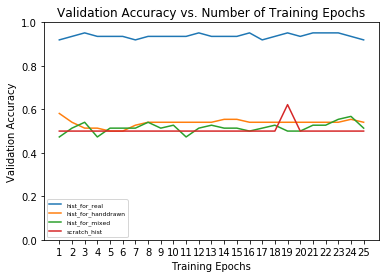

In [0]:
# Plotting time!
hist_for_real = [h for h in hist_for_real]
hist_for_handdrawn = [h for h in hist_for_handdrawn]
hist_for_mixed = [h for h in hist_for_mixed]
scratch_hist = [h for h in scratch_hist]


plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_for_real,label="hist_for_real")
plt.plot(range(1,num_epochs+1),hist_for_handdrawn,label="hist_for_handdrawn")
plt.plot(range(1,num_epochs+1),hist_for_mixed,label="hist_for_mixed")
plt.plot(range(1,num_epochs+1),scratch_hist,label="scratch_hist")

plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend(loc=3, prop={'size': 6})
plt.show()

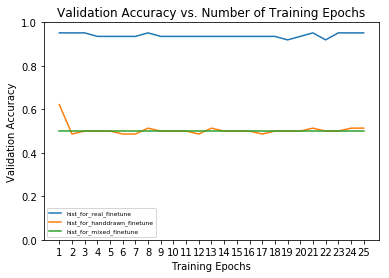

In [0]:
hist_for_real_finetune = [h for h in hist_for_real_finetune]
hist_for_handdrawn_finetune = [h for h in hist_for_handdrawn_finetune]
hist_for_mixed_finetune = [h for h in hist_for_mixed_finetune]


plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_for_real_finetune,label="hist_for_real_finetune")
plt.plot(range(1,num_epochs+1),hist_for_handdrawn_finetune,label="hist_for_handdrawn_finetune")
plt.plot(range(1,num_epochs+1),hist_for_mixed_finetune,label="hist_for_mixed_finetune")

plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend(loc=3, prop={'size': 6})
plt.show()

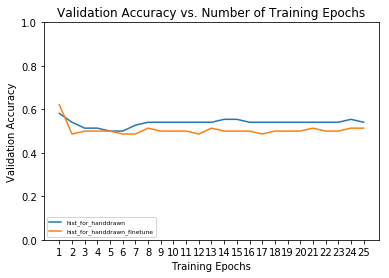

In [0]:
hist_for_handdrawn = [h for h in hist_for_handdrawn]

hist_for_handdrawn_finetune = [h for h in hist_for_handdrawn_finetune]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_for_handdrawn,label="hist_for_handdrawn")

plt.plot(range(1,num_epochs+1),hist_for_handdrawn_finetune,label="hist_for_handdrawn_finetune")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend(loc=3, prop={'size': 6})
plt.show()

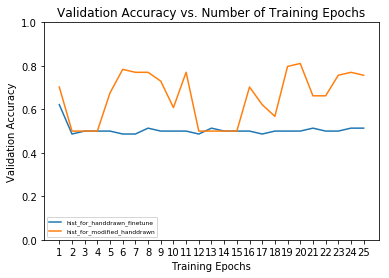

In [0]:
hist_for_handdrawn_finetune = [h for h in hist_for_handdrawn_finetune]

hist_for_modified_handdrawn = [h for h in hist_for_modified_handdrawn]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_for_handdrawn_finetune,label="hist_for_handdrawn_finetune")
plt.plot(range(1,num_epochs+1),hist_for_modified_handdrawn,label="hist_for_modified_handdrawn")


plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend(loc=3, prop={'size': 6})
plt.show()

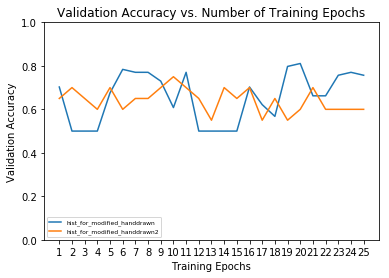

In [0]:
hist_for_modified_handdrawn = [h for h in hist_for_modified_handdrawn]
hist_for_modified_handdrawn2 = [h for h in hist_for_modified_handdrawn2]


plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),hist_for_modified_handdrawn,label="hist_for_modified_handdrawn")
plt.plot(range(1,num_epochs+1),hist_for_modified_handdrawn2,label="hist_for_modified_handdrawn2")

plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend(loc=3, prop={'size': 6})
plt.show()